# DTCam

> Capture images from pre-determined addresses

In [ ]:
#| default_exp vision.dtcam

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
from IPython.display import Image
from llmcam.gpt4v import *
from llmcam.yolo import *
from llmcam.fn_to_fc import *
from llmcam.downloader import *
import json

In [ ]:
#| export
import requests
from pathlib import Path
from PIL import Image
from io import BytesIO
from datetime import datetime
import os

In [ ]:
#| export
stations_url = "https://tie.digitraffic.fi/api/weathercam/v1/stations"

## build an addressbook of camera installed address, and image capture url
```
[
    {
        "address": <camera installed location>,
        "url": <capture image url>,
    },
    {
        "address": <camera installed location>,
        "url": <capture image url>,
    },
    ....
]
```

In [ ]:
def build_address_book(stations_url:str):
    table = []
    stations = requests.get(stations_url).json()['features']
    for station in stations:
        station = requests.get(stations_url+'/'+station['id']).json().get('properties')
        if not station:
            continue
        for preset in station['presets']:
            try:
                addr = ",".join([preset['presentationName'], station['names'].get('fi'), station['municipality'], station['province']])
            except:
                continue
            info = {
                #"id": preset['id'],
                "address": addr,
                "url": preset['imageUrl'],
            }
            table.append(info)
    return table

In [ ]:
def address_book(stations_url:str=stations_url, force_update=False):
    """get an address book [{"address":<camera installed address>, "url":<image capture url>}]"""
    if not force_update and os.path.exists("preset_image_url.json"):
        with open("preset_image_url.json", "r") as f:
            return json.load(f)
    raise
    data = build_address_book(stations_url)
    with open("preset_image_url.json", "w") as f:
        json.dump(data, f, indent=4) 
    return data

In [ ]:
#| export
def camera_address_book(
    stations_url:str=stations_url, # Weather Camera URL
    update:bool=False,             # Update addressbook forcely
)->str:                            # List of `"camera location"`:`"image url"`
    """get weather camera location addressbook of `camera location`:`image url`. You can get an capture of camera from this url"""   
    data = address_book(stations_url, update)
    return json.dumps(data)

In [ ]:
show_doc(camera_address_book)

---

[source](https://github.com/ninjalabo/llmcam/blob/main/llmcam/dtcam.py#L18){target="_blank" style="float:right; font-size:smaller"}

### camera_address_book

>      camera_address_book (stations_url:str='https://tie.digitraffic.fi/api/wea
>                           thercam/v1/stations', update:bool=False)

*get weather camera location addressbook of `camera location`:`image url`. You can get an capture of camera from this url*

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| stations_url | str | https://tie.digitraffic.fi/api/weathercam/v1/stations | Weather Camera URL |
| update | bool | False | Update addressbook forcely |
| **Returns** | **str** |  | **List of `"camera location"`:`"image url"`** |

In [ ]:
#| eval: false
tools = [tool_schema(f) for f in [camera_address_book, download_file, ask_gpt4v_about_image_file]]
msgs = form_msgs([
    ("system", "You are a helpful system administrator. Use the supplied tools to assist the user."),
    ("user", "Pick up the camera location closer to Espoo Kehä I Itään from camera address book"),
])
complete(msgs, tools=tools)
msgs.append(form_msg("user", "download captured images"))
complete(msgs, tools=tools)
msgs.append(form_msg("user", "How many cars are seen?"))
complete(msgs, tools=tools)
print_msgs(msgs)

>> System:
You are a helpful system administrator. Use the supplied tools to assist the user.
>> User:
Pick up the camera location closer to Espoo Kehä I Itään from camera address book
>> Assistant:
It seems that there is an issue accessing the camera address book. Unfortunately, I couldn't
retrieve the data needed to find the camera location closer to Espoo Kehä I Itään. Please check the
URL or try again later.
>> User:
download captured images
>> Assistant:
I still cannot access or update the camera address book to download captured images. It seems there
is an issue with the data source or URL. You may want to verify the URL or try reaching out to the
service provider for further assistance.
>> User:
How many cars are seen?
>> Assistant:
Could you please provide an image from which you'd like to know the number of cars? Alternatively,
if you have an image URL or specific camera details, please share them so I can assist you further.


## Simple capture function

In [ ]:
#| export
def stations(key:str)->list[dict]:
    "Get all weather station including `key` word"
    res = requests.get(stations_url)
    assert res.status_code == 200
    stations = res.json()['features']
    return [st for st in stations if key.lower() in st['properties']['name'].lower()]

In [ ]:
Porvoos = stations("Porvoo")
assert "porvoo" in Porvoos[0]['properties']['name'].lower()

In [ ]:
#| export
def presets(station:dict)->list[dict]:
    "Get all presets at a given weather station"
    res = requests.get(stations_url + "/" + station['id'])
    assert res.status_code == 200
    presets = res.json()['properties']['presets']
    return presets

In [ ]:
preset = presets(Porvoos[0])[0]
imageUrl = preset['imageUrl']
print(imageUrl)
assert "jpg" in imageUrl

https://weathercam.digitraffic.fi/C0150200.jpg


In [ ]:
#| export
def capture(preset:dict)->Path:
    "Capture image at a given preset location in a Weather station, and return an image path"
    req = requests.get(preset['imageUrl'], headers={'Digitraffic-User': 'NinjaLABO/LLMCAM 1.0'})
    assert req.status_code == 200
    img = Image.open(BytesIO(req.content))
    #img.show()
    dt = datetime.strptime(req.headers["last-modified"], '%a, %d %b %Y %H:%M:%S %Z')
    dtstr = dt.strftime("%Y.%m.%d_%H:%M:%S")
    dir = os.getenv("LLMCAM_DATA", "../data")
    path = f"{dir}/cap_{dtstr}_{preset['presentationName']}_{preset['id']}.jpg"
    img.save(path, format="JPEG")
    return req.headers, path

In [ ]:
preset

{'id': 'C0150200',
 'presentationName': 'Porvoo',
 'inCollection': True,
 'resolution': '704x576',
 'directionCode': '0',
 'imageUrl': 'https://weathercam.digitraffic.fi/C0150200.jpg',
 'direction': 'UNKNOWN'}

In [ ]:
hdr, path = capture(preset)
hdr

{'Content-Type': 'image/jpeg', 'Content-Length': '74438', 'Connection': 'keep-alive', 'x-amz-id-2': 'aLcvzWtuoJ9mb9a6Mv2x1iGSxRYJdlpPb5ES+hHqPpRXKRGbKPvQ3h73WNfm/E/InTo/oCvNZUo=', 'x-amz-request-id': '6RXY689VG0GNE7N4', 'last-modified': 'Mon, 09 Dec 2024 18:43:06 GMT', 'x-amz-expiration': 'expiry-date="Wed, 11 Dec 2024 00:00:00 GMT", rule-id="Delete versions and current images after 24h"', 'x-amz-server-side-encryption': 'AES256', 'X-Amz-Meta-Last-Modified': 'Mon, 09 Dec 2024 18:43:06 GMT', 'x-amz-version-id': 'jvqx99Bp7UKDNuAg1t12rANJtHU1vOOS', 'Accept-Ranges': 'bytes', 'Server': 'AmazonS3', 'Date': 'Mon, 09 Dec 2024 18:50:42 GMT', 'ETag': '"31298cafaa5316196f1faffc98219f01"', 'Vary': 'Accept-Encoding', 'X-Cache': 'Hit from cloudfront', 'Via': '1.1 2e0b0e777d576ee595b61a5d3b296990.cloudfront.net (CloudFront)', 'X-Amz-Cf-Pop': 'HEL51-P1', 'Alt-Svc': 'h3=":443"; ma=86400', 'X-Amz-Cf-Id': 'zlewy-LsVguUJz9ZyQ8cQ_8htLIy69j2mjrQhN9nMx9w6MBnS47s4w==', 'Age': '63'}

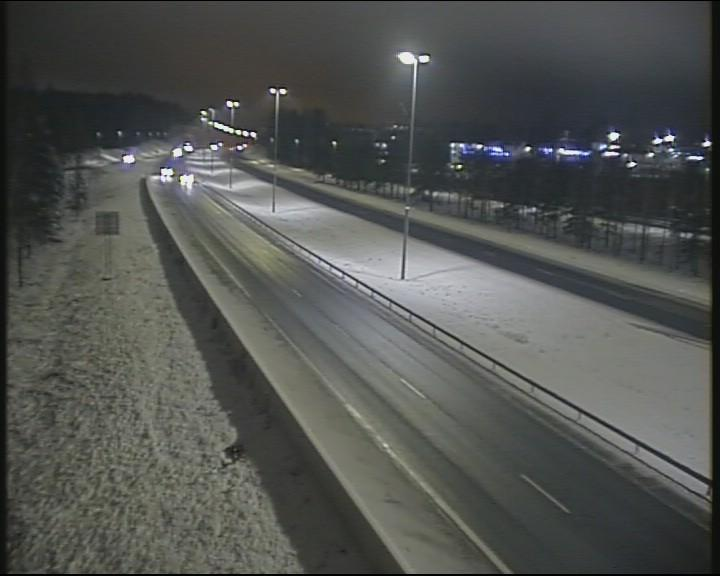

In [ ]:
display(Image.open(path))

In [ ]:
#| export
def cap(
    key:str = "Porvoo", # location keyword
)->str:
    "Capture an image at specified location, save it, and return its path"
    _, path = capture(presets(stations(key)[0])[0])
    return str(path)

In [ ]:
show_doc(cap)

---

[source](https://github.com/ninjalabo/llmcam/blob/main/llmcam/dtcam.py#L57){target="_blank" style="float:right; font-size:smaller"}

### cap

>      cap (key:str='Porvoo')

*Capture an image at specified location, save it, and return its path*

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| key | str | Porvoo | location keyword |
| **Returns** | **str** |  |  |

In [ ]:
#| eval: false
path = cap("porvoo")
print(path)
ask_gpt4v(path)

/home/nghivo/tinyMLaaS/llmcam/data/cap_2024.12.09_18:43:06_Porvoo_C0150200.jpg


{'timestamp': 'unknown',
 'location': 'unknown',
 'dimensions': '720 x 576',
 'building': 0,
 'buildings_height_range': '0 stories',
 'car': 5,
 'truck': 0,
 'boat': 0,
 'available_parking_space': 0,
 'street_lights': 10,
 'person': 0,
 'time_of_day': 'night',
 'artificial_lighting': 'prominent',
 'visibility_clear': True,
 'sky_visible': True,
 'sky_light_conditions': 'night',
 'waterbodies_visible': False,
 'waterbodies_type': 'none'}

In [ ]:
#| eval: false
detect_objects(cap('porvoo'))


image 1/1 /home/nghivo/tinyMLaaS/llmcam/data/cap_2024.12.09_18:43:06_Porvoo_C0150200.jpg: 512x640 (no detections), 62.2ms
Speed: 2.4ms preprocess, 62.2ms inference, 17.1ms postprocess per image at shape (1, 3, 512, 640)


'{}'

In [ ]:
#| eval: false
def __ask_gpt4v(
    path: str # file path to analyze
)->str:
    "ask gpt4v to analyze an image given"
    return json.dumps(ask_gpt4v(path))

In [ ]:
#| eval: false
show_doc(__ask_gpt4v)

---

### __ask_gpt4v

>      __ask_gpt4v (path:str)

*ask gpt4v to analyze an image given*

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| path | str | file path to analyze |
| **Returns** | **str** |  |

In [ ]:
#| eval: false
tools = [tool_schema(f) for f in [cap, detect_objects, __ask_gpt4v] ]
tools

[{'type': 'function',
  'function': {'name': 'cap',
   'description': 'Capture an image at specified location, save it, and return its path',
   'parameters': {'type': 'object',
    'properties': {'key': {'type': 'string',
      'description': 'location keyword'}},
    'required': []},
   'metadata': {'module': '__main__', 'service': '__main__'}}},
 {'type': 'function',
  'function': {'name': 'detect_objects',
   'description': 'Detect object in the input image.',
   'parameters': {'type': 'object',
    'properties': {'image_path': {'type': 'string',
      'description': 'Path/URL of image'},
     'conf': {'type': 'number', 'description': 'Confidence threshold'}},
    'required': ['image_path']},
   'metadata': {'module': 'llmcam.yolo', 'service': 'llmcam.yolo'}}},
 {'type': 'function',
  'function': {'name': '__ask_gpt4v',
   'description': 'ask gpt4v to analyze an image given',
   'parameters': {'type': 'object',
    'properties': {'path': {'type': 'string',
      'description': 'fil

In [ ]:
def callback(name, tools=[], **kwargs): return globals().get(name)(**kwargs)

In [ ]:
#| eval: false
msgs = form_msgs([
    ("system", "You are a helpful system administrator. Use the supplied tools to assist the user."),
    ("user", "Capture an image in Porvoo and tell me the path"),
])
complete(msgs, tools=tools)

('assistant',
 'The image has been captured in Porvoo. You can find it at the following path: `/home/nghivo/tinyMLaaS/llmcam/data/cap_2024.12.09_18:43:06_Porvoo_C0150200.jpg`.')

In [ ]:
#| eval: false
msgs.append(form_msg("user", f"analyze this captured image"))
complete(msgs, tools=tools)

('assistant',
 'The analysis of the captured image in Porvoo reveals the following details:\n\n- **Dimensions**: 576 x 720 pixels\n- **Objects Detected**:\n  - Cars: 5\n  - Trucks: 0\n  - People: 0\n  - Street Lights: 6\n  - Buildings: 0\n  - Boats: 0\n  - Available Parking Space: 0\n- **Environmental Observations**:\n  - Time of Day: Evening\n  - Artificial Lighting: Prominent\n  - Visibility: Clear\n  - Sky: Visible and Overcast\n  - Water Bodies: Not visible\n\nIf you need more detailed analysis or further information, please let me know!')

In [ ]:
#| eval: false
msgs.append(form_msg("user", "Can you detect objects in the file?"))
complete(msgs, tools=tools)


image 1/1 /home/nghivo/tinyMLaaS/llmcam/data/cap_2024.12.09_18:43:06_Porvoo_C0150200.jpg: 512x640 (no detections), 24.3ms
Speed: 1.9ms preprocess, 24.3ms inference, 0.5ms postprocess per image at shape (1, 3, 512, 640)


('assistant',
 'It seems that no specific objects were detected in the image using the object detection tool. If you have any further questions or need more analysis, feel free to ask!')

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()